In [1]:
using Revise
using LinearAlgebra
using SparseArrays
using Pkg
using DelayDiffEq 
using Plots

In [2]:
using OpenQuantumSystems

In [6]:
D(op1::Array, op2::Array) = abs(norm(op1 - op2))
D(x1::StateVector, x2::StateVector) = norm(x2 - x1)
D(op1::AbstractOperator, op2::AbstractOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))
D(op1::AbstractSuperOperator, op2::AbstractSuperOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))

HR = 0.01
shift = (2.0 * HR)
modes = [Mode(180., shift)]
mols = [
        Molecule([Mode(180., shift)], 3, [12500., 12700.]),
        Molecule([Mode(180., shift)], 3, [12500., 12700.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 50
    aggCore.coupling[mol_i+1, mol_i] = 50
end
agg = setupAggregate(aggCore)
aggCore = agg.core
aggTools = agg.tools
aggOperators = agg.operators

Ham_sys = agg.operators.Ham_sys
Ham_bath = agg.operators.Ham_bath
Ham_S = agg.operators.Ham_S
Ham_B = agg.operators.Ham_B
Ham_I = agg.operators.Ham_I
Ham_0 = agg.operators.Ham_0
Ham = agg.operators.Ham

basis = agg.tools.basis
indicesLen = agg.tools.bSize
indices = agg.tools.indices
indicesMap = agg.tools.indicesMap
FCFact = agg.tools.FCfactors
FCProd = agg.tools.FCproduct

Ham_0
Ham_0_lambda, Ham_0_S = eigen(Ham_0.data)
Ham_0_Sinv = inv(Ham_0_S)
Ham_0_lambda = diagm(Ham_0_lambda)
println("")

In [7]:
t_max = 0.01
t_count = 200
t0 = 0.
t_step = (t_max - t0) / (t_count)
tspan = [t0:t_step:t_max;]

T = 300
mu_array = [[2, 1]]
W0_1 = thermal_state(T, [[2, 1]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_2 = thermal_state(T, [[1, 2]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_3 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
W0_4 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
a1 = indicesMap[2][1]; a2 = indicesMap[2][end]
b1 = indicesMap[3][1]; b2 = indicesMap[3][end]
W0_3.data[a1:a2, b1:b2] = W0_2.data[b1:b2, b1:b2]
W0_4.data[b1:b2, a1:a2] = W0_2.data[b1:b2, b1:b2]
W0 = 0.8*W0_1 + 0.2*W0_2 + 0.1*W0_3 + 0.1*W0_4
W0 = DenseOperator(W0.basis_l, W0.basis_r, complex(W0.data))

# data = Matrix(Hermitian(rand(ComplexF64, indicesLen, indicesLen)))
# W0 = DenseOperator(basis, basis, data)
# normalize!(W0)

W0_bath = get_rho_bath(W0, aggCore, aggTools)
W0_bath = DenseOperator(W0_bath.basis_l, W0_bath.basis_r, complex(W0_bath.data))

rho0 = trace_bath(W0, aggCore, aggTools)
rho0 = DenseOperator(rho0.basis_l, rho0.basis_r, complex(rho0.data))

println("")

In [8]:
using OpenQuantumSystems
@time T, W_t = master(
    W0,
    tspan,
    agg;
    reltol = 1.0e-3,
    abstol = 1.0e-3,
    int_reltol = 1.0e-4,
    int_abstol = 1.0e-4,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5())
)
println("")

  1.532012 seconds (176.67 k allocations: 1.848 GiB, 15.57% gc time)



In [16]:
W_t_exact = zeros(ComplexF64, length(tspan), agg.tools.bSize, agg.tools.bSize)
t_i = 0

for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham, t)
    W = U_op * W0 * U_op'
    W_t_exact[t_i, :, :] = W.data
end

1 0.0
1 0.0
2 0.0006971481877400486
2 0.002090909672139751
3 0.001374789952904388
3 0.004123315484366843
4 0.0020332307289201964
4 0.00609813348471597
5 0.002672773695633918
5 0.008016272962511764
6 0.0032937197797638655
6 0.009878636449712661
7 0.003896367655352845
7 0.011686119722254645
8 0.004481013744220826
8 0.01343961180139484
9 0.005047952216417559
9 0.015139994955054803
10 0.005597474990675712
10 0.016788144699165116
11 0.006129871734862881
11 0.018384929799006265
12 0.0066454298664352885
12 0.019931212270554492
13 0.007144434552889644
13 0.021427847381821682
14 0.007627168712216416
14 0.022875683654199504
15 0.00809391301335269
15 0.024275562863801694
16 0.00854494587663397
16 0.025628320042803094
17 0.008980543474247964
17 0.02693478348078438
18 0.009400979730686699
18 0.028195774726071293
19 0.009806526323198696
19 0.029412108587074038
20 0.010197452682242009
20 0.03058459313362844
21 0.010574025991936369
21 0.03171402969833486
22 0.010936511190515998
22 0.032801212877897966

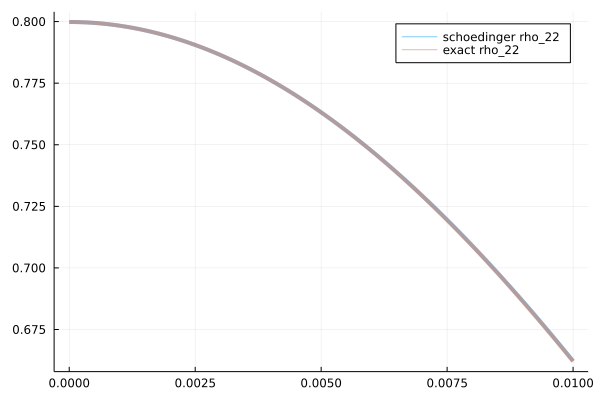

In [10]:

elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)

for t_i in 1:length(tspan)
    rho_t[t_i, :, :] = trace_bath(W_t[t_i].data, aggCore, aggTools)
    rho_t_exact[t_i, :, :] = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    println(t_i, " ", D(W_t[t_i].data, W_t_exact[t_i, :, :]))
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 2, 2]), label="schoedinger rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

In [4]:
HR = 0.01
shift = (2.0 * HR)
modes = [Mode(180., shift)]
mols = [
        Molecule([Mode(180., shift)], 3, [12500., 12700.]),
        Molecule([Mode(180., shift)], 3, [12500., 12700.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 50
    aggCore.coupling[mol_i+1, mol_i] = 50
end
agg = setupAggregate(aggCore)
aggCore = agg.core
aggTools = agg.tools
aggOperators = agg.operators

Ham_sys = agg.operators.Ham_sys
Ham_bath = agg.operators.Ham_bath
Ham_S = agg.operators.Ham_S
Ham_B = agg.operators.Ham_B
Ham_I = agg.operators.Ham_I
Ham_0 = agg.operators.Ham_0
Ham = agg.operators.Ham
indicesMap = agg.tools.indicesMap
indicesLen = agg.tools.bSize
data = Matrix(Hermitian(rand(ComplexF64, indicesLen, indicesLen)))
W0 = DenseOperator(agg.tools.basis, agg.tools.basis, data)
println("")

In [22]:
t_max = 0.0001
t_count = 200
t0 = 0.
t_step = (t_max - t0) / (t_count)
tspan = [t0:t_step:t_max;]

T = 300
mu_array = [[2, 1]]
W0_1 = thermal_state(T, [[2, 1]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_2 = thermal_state(T, [[1, 2]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_3 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
W0_4 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
a1 = indicesMap[2][1]; a2 = indicesMap[2][end]
b1 = indicesMap[3][1]; b2 = indicesMap[3][end]
W0_3.data[a1:a2, b1:b2] = W0_2.data[b1:b2, b1:b2]
W0_4.data[b1:b2, a1:a2] = W0_2.data[b1:b2, b1:b2]
W0 = 0.8*W0_1 + 0.2*W0_2 + 0.1*W0_3 + 0.1*W0_4
W0 = DenseOperator(W0.basis_l, W0.basis_r, complex(W0.data))

@time T, W_t = master(
    W0,
    tspan,
    agg;
    reltol = 1.0e-7,
    abstol = 1.0e-7,
    int_reltol = 1.0e-8,
    int_abstol = 1.0e-8,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Vern7())
)

for t_i = 1:length(tspan)
    t = tspan[t_i]
    W = W_t[t_i]
    U_op = evolutionOperator(Ham, t)
    W_ref = U_op * W0 * U_op'
    println(t_i, " ", D(W_ref, W))
    rho_t = trace_bath(W, aggCore, aggTools)
    rho_t_ref = trace_bath(W_ref, aggCore, aggTools)
    println(t_i, " ", D(rho_t_ref, rho_t))
    # @test 1e-4 > D(W_ref, W)
end

 44.266202 seconds (35.67 M allocations: 43.151 GiB, 5.10% gc time, 0.25% compilation time)
1 0.0
1 0.0
2 1.8764882017141425e-14
2 1.866877225208236e-14
3 7.356938418491403e-14
3 7.319321096328485e-14
4 1.6225198763508926e-13
4 1.6142253983602755e-13
5 2.8274481914376046e-13
5 2.8129940311518044e-13
6 4.3306942872377957e-13
6 4.3085551101440147e-13
7 6.113369031628816e-13
7 6.082116639393395e-13
8 8.157477257691122e-13
8 8.115774883345366e-13
9 1.0445791582124047e-12
9 1.0392391783652584e-12
10 1.29619171033347e-12
10 1.289565419630087e-12
11 1.5690249013154721e-12
11 1.561003795537517e-12
12 1.8615898047040924e-12
12 1.8520731263014992e-12
13 2.1724750581859724e-12
13 2.1613690636443874e-12
14 2.5003355173883523e-12
14 2.4875534199542526e-12
15 2.8439012645425912e-12
15 2.829362793463356e-12
16 3.2019538483191e-12
16 3.1855850422874616e-12
17 3.573355987967503e-12
17 3.5550884117656553e-12
18 3.9570170434638785e-12
18 3.936788045748557e-12
19 4.3519126315929806e-12
19 4.32966501132488

In [7]:
using OpenQuantumSystems
include("test_master.jl")


Test Summary: |
master        | No tests


Test.DefaultTestSet("master", Any[], 0, false, false)

In [8]:
names = [
    "test_operators_dense.jl",
    "test_superoperators.jl",
    "test_metrics.jl",
    "test_molecules.jl",
    "test_aggregateCore.jl",
    "test_aggregateTools.jl",
    "test_aggregateOperators.jl",
    "test_aggregate.jl",
    "test_evolution.jl",
    "test_schroedinger.jl",
    "test_liouville.jl",
    "test_interaction_picture.jl",
    "test_master.jl",
    "test_trace.jl",
    "test_initial_state.jl",
    "test_memory_kernel.jl",
    "test_master_ansatz.jl",
]

for name in names
    include(name)
end

Test Summary:   | Pass  Total
operators dense |    6      6
Test Summary:  | Pass  Total
superoperators |    2      2
Test Summary: | Pass  Total
metrics       |   19     19
Test Summary: | Pass  Total
molecules     |   20     20
Test Summary: | Pass  Total
aggregateCore |   14     14
Test Summary:  | Pass  Total
aggregateTools |   12     12
Test Summary:      | Pass  Total
aggregateOperators |    7      7
Test Summary: | Pass  Total
aggregate     |    3      3
Test Summary: | Pass  Total
evolution     |   54     54
Test Summary: | Pass  Total
schroedinger  |   25     25
Test Summary: | Pass  Total
liouville     |   11     11
Test Summary:       | Pass  Total
interaction picture |    9      9
Test Summary: |
master        | No tests
Test Summary: | Pass  Total
trace         |   41     41
Test Summary: | Pass  Total
initial state |    8      8
Test Summary: | Pass  Total
memory kernel |   51     51
Test Summary: |
master ansatz | No tests
